In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

In [2]:
def ecdf(data):
    plt.plot(np.sort(data), np.linspace(0,1,len(data)))

## Data loading

In [3]:
train_o = pd.read_csv("data/train.csv")
test_o = pd.read_csv("data/test.csv")

In [4]:
train_o.head()

,id,last_price,mid,opened_position_qty,closed_position_qty,transacted_qty,d_open_interest,bid1,bid2,bid3,...,bid2vol,bid3vol,bid4vol,bid5vol,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol,y
0,0,3842.4,3842.6,NaN,NaN,103.0,0,3842.4,3842.0,3841.8,...,1,6,14,6,6,1,1,10,2,1
1,1,3842.8,3843.4,6.0,49.0,55.0,-43,3843.0,3842.8,3842.4,...,6,11,1,6,1,4,4,1,13,0
2,2,3844.0,3844.3,7.0,77.0,84.0,-69,3843.8,3843.6,3843.2,...,1,4,21,12,1,16,10,4,9,0
3,3,3843.8,3843.4,3.0,34.0,37.0,-30,3843.0,3842.8,3842.4,...,13,12,2,4,2,7,1,2,11,1
4,4,3843.2,3843.1,3.0,38.0,41.0,-35,3842.8,3842.4,3842.0,...,12,2,2,4,1,3,1,11,15,1


In [5]:
def fillize(data):
    """Replace NaNs with zero, and adds indicator
    *only checks opened_position_qty"""
    nans = np.isnan(data["opened_position_qty"])
    return data.fillna(0).assign(nans=nans)

def deidize(data):
    """drop id column"""
    return data.drop("id", axis=1)

def relize(data):
    """replace bid[i] and ask[i] columns with
    bid[i]-bid[i-1] ans ask[i]-ask[i-1]"""
    rel = data.copy()
    for i in range(5,1,-1):
        rel[f"bid{i}"] = rel[f"bid{i-1}"] - rel[f"bid{i}"]
        rel[f"ask{i}"] -= rel[f"ask{i-1}"]

    rel["bid1"] = rel["last_price"] - rel["bid1"]
    rel["ask1"] -= rel["last_price"]
    return rel

import sklearn.preprocessing
def normall(datas):
    """standardize last_price, mid, and d_open_interest"""
    scaler_price = sklearn.preprocessing.StandardScaler()
    scaler_price.fit(datas[0][["last_price"]])
    scaler_interest = sklearn.preprocessing.StandardScaler()
    scaler_interest.fit(datas[0][["d_open_interest"]])

    normeds = []
    for data in datas:
        normed = data.copy()
        normed[["last_price","mid"]] = scaler_price.transform(normed[["last_price","mid"]])
        normed[["d_open_interest"]] = scaler_interest.transform(normed[["d_open_interest"]])
        normeds.append(normed)
    return normeds

def logize(data):
    cols = sum([
        ["opened_position_qty", "closed_position_qty", "transacted_qty"]
        #[f"bid{i}" for i in range(2,6)],
        #[f"bid{i}vol" for i in range(1,6)],
        #[f"ask{i}" for i in range(2,6)],
        #[f"ask{i}vol" for i in range(1,6)],
    ], [])
    logged = data.copy()
    logged.loc[:,cols] = np.log1p(logged.loc[:,cols])
    return logged

import sklearn.model_selection
def splitize(data):
    """make train and validation set"""
    return sklearn.model_selection.train_test_split(data.drop("y",axis=1), data["y"])

In [6]:
prepr = lambda data:logize(fillize(relize(deidize(data))))

ftrainX, ftrainY = normall([prepr(train_o.drop("y",axis=1))])[0], train_o["y"]

trainX, valX, trainY, valY = splitize(train_o)
trainX, valX, testX = normall([prepr(trainX), prepr(valX), prepr(test_o)])

In [7]:
trainX.head()

,last_price,mid,opened_position_qty,closed_position_qty,transacted_qty,d_open_interest,bid1,bid2,bid3,bid4,...,bid2vol,bid3vol,bid4vol,bid5vol,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol,nans
479869,0.358632,0.358632,1.386294,0.000000,1.386294,1.305529,0.2,0.2,0.2,0.2,...,11,2,2,2,6,4,11,4,12,False
299661,0.407553,0.408776,0.000000,0.693147,0.693147,-0.387365,0.0,0.2,0.2,0.2,...,1,1,3,3,1,6,12,11,17,False
498942,0.532303,0.526188,0.693147,1.098612,1.386294,0.035859,0.6,0.2,0.2,0.2,...,8,10,21,9,1,7,4,2,1,False
205819,-0.776350,-0.776350,0.000000,0.000000,0.000000,0.035859,0.2,0.4,0.2,0.2,...,1,2,4,6,1,5,10,15,2,True
143856,-0.722536,-0.718867,1.098612,0.693147,1.386294,0.459082,0.0,0.2,0.2,0.2,...,5,6,14,2,4,3,3,3,2,False


## Ridge

0.6438205804199866

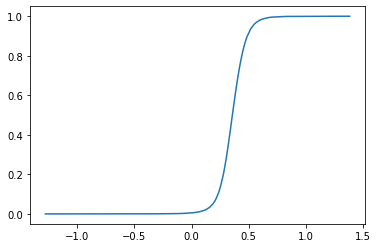

In [8]:
import sklearn.linear_model
ridge = sklearn.linear_model.Ridge()
ridge.fit(trainX, trainY)
p = ridge.predict(valX)
ecdf(p)
sklearn.metrics.roc_auc_score(valY, p)

## Predict

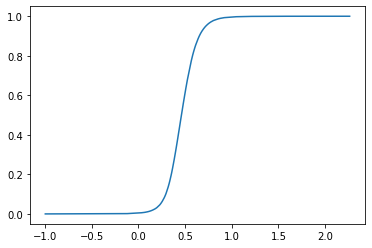

In [9]:
# fit on all data and predict
ridge = sklearn.linear_model.Ridge()
ridge.fit(ftrainX, ftrainY)
p = ridge.predict(testX)
ecdf(p)

In [10]:
# final output requires values in [0,1]
pscale = (p - np.min(p)) / (np.max(p)-np.min(p))
out = pd.DataFrame({"id":test_o.iloc[:,0], "Predicted":pscale})

with open("stockrdigeprepr.csv", "w") as f:
    f.write(out.to_csv(index=False))